In [26]:
#Computação científica
import numpy as np

#análise de dados
import pandas as pd

#machine learning
from sklearn.linear_model import LogisticRegression #regressão lasso
from sklearn.model_selection import GridSearchCV, KFold
import lightgbm as lgb


#mtricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve


#visualização
import matplotlib.pyplot as plt
import seaborn as sns

#sampling
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

#pipeline
from imblearn.pipeline import Pipeline

#cross validation
from sklearn.model_selection import StratifiedKFold

#barra indicando porcentagem de conclusão
from tqdm import tqdm

#tuning de modelo
import optuna



#Parâmetros

In [27]:
#Definir a seed para que os resultados obtidos sejam sempre os mesmos

seed=0

In [28]:
#Estilo dos gráficos do seaborn

sns.set_theme(style="darkgrid")


In [43]:
#se train_models=False os modelos não serão treinado. Eles já foram previamente treinados e os resultados serão carregados da memória
#se train_models=True os modelos serão treinados
train_models=False

# Carregar *Dados*

In [29]:
path='/content/drive/MyDrive/Rodolfo/porto/porto-seguro-safe-driver-prediction/'



Teste com dois datasets selecionados no processo de feature selection

1.   Dataset com as features selecionadas pela correlação para ser usado com LightGBM;
2.   Dataset com 54 features selecionadas com uso dos coeficientes da regressão para ser usado comoinput para regressão logistica.



In [30]:
#Dados com colunas selecionadas através do calculo da correlação para uso com LighGBM

x_train_corr = pd.read_csv(path+'train_selected_features_transformed.csv')
x_val_corr   = pd.read_csv(path+'val_selected_features_transformed.csv')

y_train_corr = np.ravel(pd.read_csv(path+'y_train.csv'))
y_val_corr   = np.ravel(pd.read_csv(path+'y_val.csv'))

print("Número de features: {}".format(np.shape(x_train_corr)[1]))

Número de features: 108


In [31]:
#Dados com colunas selecionadas através dos coeficientes da regressão para uso com regressão logistica

x_train_lr=pd.read_csv(path+'x_train_lr.csv')
x_val_lr  =pd.read_csv(path+'x_val_lr.csv')

y_train_lr = np.load(path+'y_train_lr.npy')
y_val_lr   = np.load(path+'y_val_lr.npy')



# Funções para Treinamento dos modelos

In [ ]:
#Função para treinar modelo com stratifiedkfold
def calcular_auc_stratifiedkfold(model,x,y,n_splits=10,amostragem=None):
  """
  Função para treinar um modelo com o uso de stratifiedkfold e retornar uma lista com
  o roc_auc score para os dados de cada uma das folds

  Inputs:
    model    - instância de um objeto. O objeto é um modelo que será usado no treinamento
    x        - (pandas dataframe) dados de entrada do modelo
    y        - (np array) output esperado do moldelo
    n_splits - (int) número de splits usadas na validação cruzada
    amostragem - determinar se os dados serão amostrados para o treinamento do modelo. Se amostragem = None
                 não será aplicada nenhuma amostragem. PAra aplicar ume método de amostragem a variável amostragem
                 deve recebem um objeto com método fit_resample

  Outputs
    auc     - (list) lista com o auc score obtido com os dados separados para teste na validação cruzada
   """

  #criação de objeto stratifiedkfold
  skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
  auc  = []
  progress_bar = tqdm(total=n_splits)
  for train_index, test_index in skf.split(x, y):
      x_train_fold, x_test_fold = x.loc[train_index,:], x.loc[test_index,:]
      y_train_fold, y_test_fold = y[train_index], y[test_index]
      if amostragem is not None:
        x_train_fold, y_train_fold=amostragem.fit_resample(x_train_fold, y_train_fold)
      model.fit(x_train_fold, y_train_fold)
      auc.append( roc_auc_score(y_test_fold,model.predict_proba(x_test_fold)[:,1]))
      progress_bar.update(1)
  return auc

# Técnicas de Amostragem

## Random Undersamplig + Smote

In [38]:
#razão entre o número de amostras da classe minoritária e da classe majoritária

np.sum(y_train_lr==1)/np.sum(y_train_lr==0)

0.03782674325340879

Undersampling da classe majoritária para aumentar a razão o número de amostras da classe minoritária e da classe majoritária

In [39]:
#random undersampling
razao=0.1 #razão entre o número de amostras da classe minoritária e da classe majoritária
ru=RandomUnderSampler(sampling_strategy=razao,random_state=seed)


Oversampling da classe minoritária para igualar o número de amostras das duas classes.


In [40]:
smote=SMOTE(random_state=seed)

Agrupar as duas transformações em uma pipeline

In [41]:
pipe_rus=Pipeline([('random undersampling',ru),
                   ('Smote',smote)])

## Smote + Tomek Links

Oversampling da classe minoritária com Smote e undersampling da classe majoritária com Tomek links.

In [42]:
smt=SMOTETomek(random_state=seed)

# Logistic Regression

Treinamento da Regressão Logística com o dataset original e com duas técnicas de amostragem. São elas:

1.   Random Undersampling + Smote
2.   Smote + Tomek Links



In [33]:
#modelo
logistic_model = LogisticRegression(random_state=seed,penalty='l1',C=0.1,solver='saga',max_iter=1000)


In [48]:
if train_models:
  resultado_baseline_lr = calcular_auc_stratifiedkfold(logistic_model,x_train_lr,y_train_lr)
  resultado_rus_lr      = calcular_auc_stratifiedkfold(logistic_model,x_train_lr,y_train_lr,amostragem=pipe_rus)
  resultado_smt_lr      = calcular_auc_stratifiedkfold(logistic_model,x_train_lr,y_train_lr,amostragem=smt)

  resultado_lr=pd.DataFrame({'baseline': resultados_baseline_lr,
                              'random undersampling + smote': resultados_rus_lr,
                              'smote + tomek links': resultados_smt_lr})

  resultado_lr.to_csv('resultado_lr.csv',index=False)

else:
  resultado_lr=pd.read_csv(path+'resultado_lr.csv')

Text(0, 0.5, 'ROC AUC')

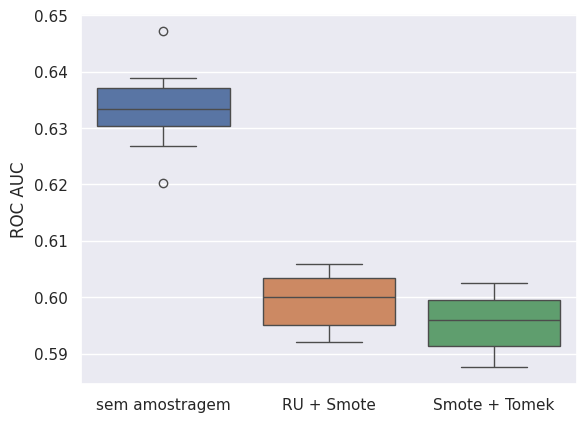

In [55]:
sns.boxplot(resultado_lr)
plt.ylabel('ROC AUC')

O uso de técnicas de amostragem não gerou melhoras no resultado.

# LightGBM

Treinamento de LightGBM com o dataset original e com duas técnicas de amostragem. São elas:

1. Random Undersampling + Smote
2. Smote + Tomek Links

In [53]:
#modelo
lgb_model = lgb.LGBMClassifier(importance_type='gain',n_estimators=1000)


In [54]:
if train_models:
  resultado_baseline_lgb = calcular_auc_stratifiedkfold(lgb_model,x_train_corr,y_train_corr)
  resultado_rus_lgb      = calcular_auc_stratifiedkfold(lgb_model,x_train_corr,y_train_corr,amostragem=pipe_rus)
  resultado_smt_lgb      = calcular_auc_stratifiedkfold(lgb_model,x_train_corr,y_train_corr,amostragem=smt)

  resultado_lr=pd.DataFrame({'baseline': resultados_baseline_lgb,
                              'random undersampling + smote': resultados_rus_lgb,
                              'smote + tomek links': resultados_smt_lgb})

  resultado_lgb.to_csv('resultado_lgb.csv',index=False)

else:
  resultado_lgb=pd.read_csv(path+'resultado_lgb.csv')



Text(0, 0.5, 'ROC AUC')

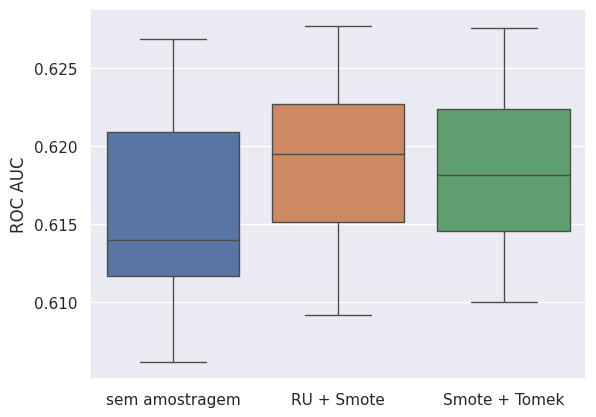

In [56]:
sns.boxplot(resultado_lgb)
plt.ylabel('ROC AUC')

A aplicação de técnicas de amostragem para balancear o número de amostras no dataset melhorou os resultados obtidos.